# What is cooking introduction in R
Adopted from:
https://www.kaggle.com/amhchiu/whats-cooking/bag-of-ingredients-in-r/code


In [1]:
#install.packages("rpart.plot", repos="http://cran.rstudio.com/")
#install.packages("jsonlite", repos="http://cran.rstudio.com/")
#install.packages("dplyr", repos="http://cran.rstudio.com/")
#install.packages("tm", repos="http://cran.rstudio.com/")
#install.packages("caret", repos="http://cran.rstudio.com/")
#install.packages("ggplot2", repos="http://cran.rstudio.com/")
#install.packages('randomForest', repos="http://cran.rstudio.com/")

Warning message:
: unable to access index for repository http://cran.rstudio.com/src/contribWarning message:
: package 'tm' is not available (for R version 3.2.1)

In [5]:
library(randomForest)
library(jsonlite)
library(dplyr)
library(ggplot2)
library(tm) # For NLP; creating bag-of-words
library(caret)
library(rpart)
library(rpart.plot)

randomForest 4.6-10
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine



In [6]:
test <- fromJSON("whatscookingtest.json", flatten = TRUE)
train <- fromJSON("whatscookingtrain.json", flatten = TRUE)


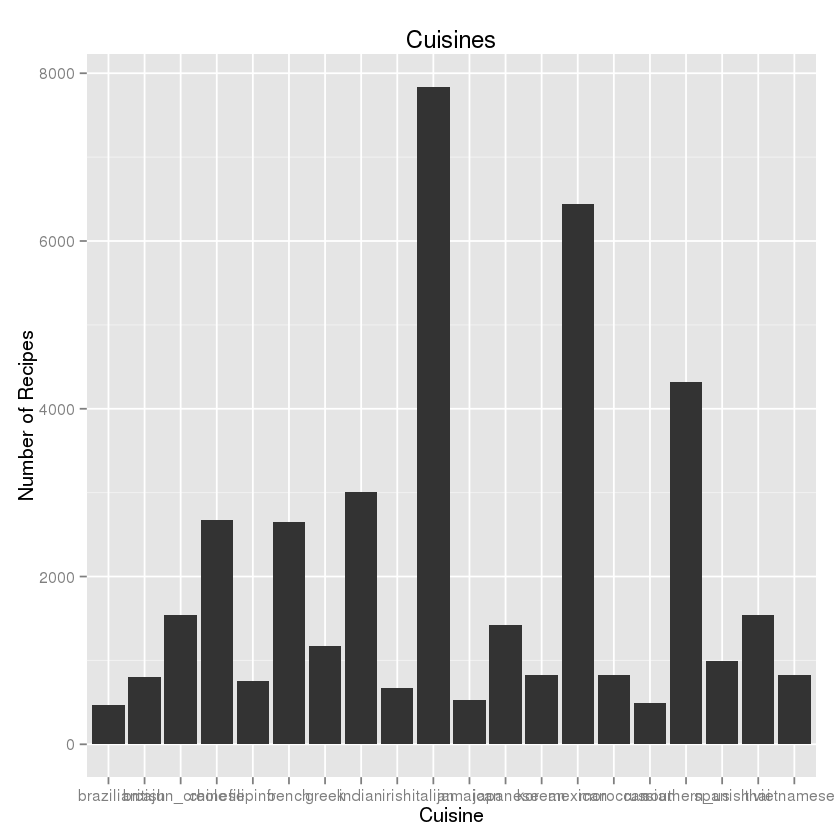

In [7]:
#Now let's take a look at the data. 
ggplot(data = train, aes(x = cuisine)) + 
  geom_histogram() +
  labs(title = "Cuisines", x = "Cuisine", y = "Number of Recipes")

In [9]:
#Wow, that graph seemed interesting, but I can't read it.  Let's instead save it to a file. Much better.
#First we assign the chart to an object. 
ggoutput<-ggplot(data = train, aes(x = cuisine)) + 
    geom_histogram() +
    labs(title = "Cuisines", x = "Cuisine", y = "Number of Recipes")

#This saves it to a file
ggsave(ggoutput, file="ggoutput.pdf", scale=2)

Saving 14 x 14 in image


In [10]:
#We also know how to aggregate to see this. 
table(train$cuisine)



   brazilian      british cajun_creole      chinese     filipino       french 
         467          804         1546         2673          755         2646 
       greek       indian        irish      italian     jamaican     japanese 
        1175         3003          667         7838          526         1423 
      korean      mexican     moroccan      russian  southern_us      spanish 
         830         6438          821          489         4320          989 
        thai   vietnamese 
        1539          825 

In [11]:
#Let's create the Niave Model based on those results. 
test$cuisine ="italian"

In [12]:
#Create Dataframe For Submission
submission<-test[,c('id','cuisine')]

#Naive Model (This is our benchmark. 0.19268 Accuracy and 693 place)  Boom. we just beat 17 people. 
write.csv(submission, "submission.csv", row.names=FALSE)



In [16]:
#Now let's start the process of creating a corpus
MyCorpus <- Corpus(VectorSource(train$ingredients))
MyCorpus2 <- Corpus(VectorSource(test$ingredients))


In [17]:
#Observe the corpus before and after this. 
MyCorpus <- tm_map(MyCorpus, stemDocument, lazy=TRUE)
MyCorpus2 <- tm_map(MyCorpus2, stemDocument, lazy=TRUE)

In [18]:
#This creates a Document Term Matrix. 
ingredientsDTM <- DocumentTermMatrix(MyCorpus)
ingredientsDTM2 <- DocumentTermMatrix(MyCorpus2)

Warning message:
In mclapply(x$content[i], function(d) tm_reduce(d, x$lazy$maps)): all scheduled cores encountered errors in user codeWarning message:
In mclapply(unname(content(x)), termFreq, control): all scheduled cores encountered errors in user code

ERROR: Error in UseMethod("meta", x): no applicable method for 'meta' applied to an object of class "try-error"


Warning message:
In mclapply(x$content[i], function(d) tm_reduce(d, x$lazy$maps)): all scheduled cores encountered errors in user codeWarning message:
In mclapply(unname(content(x)), termFreq, control): all scheduled cores encountered errors in user code

ERROR: Error in UseMethod("meta", x): no applicable method for 'meta' applied to an object of class "try-error"


In [19]:
#This removes most of the terms.  We are just going to start with a few. 
sparse <- removeSparseTerms(ingredientsDTM, 0.995)
sparse2 <- removeSparseTerms(ingredientsDTM2, 0.995)

ERROR: Error in inherits(x, c("DocumentTermMatrix", "TermDocumentMatrix")): object 'ingredientsDTM' not found


ERROR: Error in inherits(x, c("DocumentTermMatrix", "TermDocumentMatrix")): object 'ingredientsDTM2' not found


In [49]:
#This goes through the process of changing out term document matrix to a data frame we can use for marketing
ingredientsDTM <- as.data.frame(as.matrix(sparse))
ingredientsDTM2 <- as.data.frame(as.matrix(sparse2))

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 1

[[1]]
<<PlainTextDocument>>
Metadata:  7
Content:  chars: 108



In [38]:
#We have a problem though....We only want to use terms 
trainColumns<-names(ingredientsDTM)
testColumns<-names(ingredientsDTM2)

intersect<-intersect(trainColumns,testColumns)

In [42]:
#This removes about 10 columns that aren't in both. 
ingredientsDTM<- ingredientsDTM[,c(intersect)]
ingredientsDTM2<- ingredientsDTM2[,c(intersect)]

Warning message:
In mclapply(unname(content(x)), termFreq, control): all scheduled cores encountered errors in user code

ERROR: Error in UseMethod("meta", x): no applicable method for 'meta' applied to an object of class "try-error"


In [ ]:
ingredientsDTM$cuisine <- as.factor(train$cuisine)

In [ ]:
set.seed(9347)
cartModelFit <- rpart(cuisine ~ ., data = ingredientsDTM, method = "class")
prp(cartModelFit)

In [ ]:
#This generates the class prediction.  
cartPredict<-predict(cartModelFit, newdata = ingredientsDTM2, type = "class")

In [ ]:
#This creates our final submission data frame. 
submit <- data.frame(id = test$id, cuisine = cartPredict)

#Tree  Now the accuracy is 0.40115.  We have improved!
write.csv(submit, file = "myfirstdtree.csv", row.names = FALSE)


In [ ]:
#It seems that random forests package doesn't work with "-" in the column name. You can try yourself.
names(ingredientsDTM) <- gsub("-", "", names(ingredientsDTM))
names(ingredientsDTM2) <- gsub("-", "", names(ingredientsDTM2))

In [ ]:
#Boom with 1 tree we improved to an accuracy of  0.54354
forestmodel <- randomForest(cuisine ~ ., data=ingredientsDTM, importance=TRUE, ntree=1)
forestPredict<-predict(forestmodel, newdata = ingredientsDTM2, type = "class")



In [ ]:
#Create Submssion Data Frame
submit3 <- data.frame(id = test$id, cuisine = forestPredict)
write.csv(submit3, file = "3_forest.csv", row.names = FALSE)

In [ ]:
#Double boom with 100 trees we move up even further to  0.74387
forestmodel <- randomForest(cuisine ~ ., data=ingredientsDTM, importance=TRUE, ntree=100)
forestPredict<-predict(forestmodel, newdata = ingredientsDTM2, type = "class")

In [ ]:
#Create Submssion Data Frame
submit4 <- data.frame(id = test$id, cuisine = forestPredict)
write.csv(submit4, file = "4_forest.csv", row.names = FALSE)


In [ ]:
#Where to go next: 
#Let's try some more feature engineerning. 
ingredientsDTM$ingredients_count  <- rowSums(ingredientsDTM)

#Another strategy could be to create a corpus from both the training and the test set. 
MyCorpus3  <- c(Corpus(VectorSource(train$ingredients)), Corpus(VectorSource(test$ingredients)))